# Modeling Yelp Data

Paul Lim

## Libraries

In [2]:
# Main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# sklearn
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import pipeline, feature_selection, decomposition
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.externals import joblib
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

# NLP 
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
import gensim
import snowballstemmer

# Misc.
import re
import datetime
import time
import logging
import math

% matplotlib inline

sns.set_style("white")
sns.set_style('ticks')
sns.set_style({'xtick.direction': u'in', 'ytick.direction': u'in'})
sns.set_style({'legend.frameon': True})

## Running List of Functions/Classes

### Classes

In [41]:
class DataframeToSeriesTransformer(BaseEstimator, TransformerMixin):
        
    def __init__(self, col=None):
        self.col = col
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.col:
            return X[self.col]
        else:
            return X
        
class SeparateFeaturesTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_cols=None, text_cols=None):
        self.num_cols = num_cols
        self.text_cols = text_cols
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.num_cols:
            return X.loc[:, self.num_cols]
        elif self.text_cols:
            return X.loc[:, self.text_cols]
        else:
            return X
        
class WilsonAverageTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_col=None, biz_list=None):
        self.num_col = num_col
        self.biz_list = biz_list
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.num_col and self.biz_list.all():
            scores = get_average_rating(X, self.biz_list)
            
            X_avg = pd.DataFrame({'average': scores})
            
            return X_avg
        else:
            return X
        
class CleanTextTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, text_col=None):
        self.text_col = text_col
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
#         NLP = spacy.load('en')
        stemmer = snowballstemmer.EnglishStemmer()
        stop = stopwords.words('english')
        stop_list = stemmer.stemWords(stop)
        stop_list = set(stop_list)
        stop = set(stop + list(stop_list))
        
        if self.text_col:
            df = pd.DataFrame()
            clean_review_list = []
            
            for review in X.loc[:, self.text_col]:
                clean_review = ''
                
                for word in TextBlob(review).words:
                    if word not in stop:
                        clean_review += word.lemmatize() + ' '
                        
#                 clean_review = NLP(clean_review)
                clean_review_list.append(clean_review)
                        
            df['clean_reviews'] = clean_review_list
            
            return df
        else:
            return X
        
class DensifyTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.toarray()
    
class SentimentTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_col=None):
        self.text_col = text_col
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        if self.text_col:
            df = pd.DataFrame()
            sum_pol_list = []
            sum_sub_list = []

            for doc in X[self.text_col]:
                sum_pol = 0
                sum_sub = 0
                doc_blob = TextBlob(doc)

                for sent in doc_blob.sentences:
                    sum_pol += sent.sentiment[0]
                    sum_sub += sent.sentiment[1]

                sum_pol_list.append(sum_pol)
                sum_sub_list.append(sum_sub)

            df['pol'] = sum_pol_list
            df['sub'] = sum_sub_list
            return df
        else:
            return X
     

### Functions

In [91]:
def confidence(pos, neg):
    '''
    Calculates the Wilson confidence where pos is the number of positive ratings
    and neg is the number of negative ratings.
    '''
    n = pos + neg
    
    if n == 0:
        return 0
    z = 1.96 # 95% confidence interval
    phat = float(pos) / n
    return (((phat + z*z/(2*n) - z * np.sqrt((phat*(1-phat)+z*z/(4*n))/n))/(1+z*z/n)))

def get_average_rating(df, biz_list):
    '''
    Compiles the list of average ratings for each business in biz_list.
    '''
    wils_list = []
    
    for biz in biz_list:
        ind_biz = df[df['name'] == biz]
        
        pos_count = 0
        neg_count = 0
        
        for rating in ind_biz['rating']:
            if rating > 3:
                pos_count += 1
            else:
                neg_count += 1
        
        wils_conf = confidence(pos_count, neg_count)
        wils_list.append(wils_conf)
    return wils_list

def sample_cluster(df, group_by_cols, size=5):
    sample_fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace=True), :]
    df = df.groupby(group_by_cols, as_index=False).apply(sample_fn)
    
    return df

## Data Preprocessing

### Load in data

In [8]:
df_init = joblib.load('../data/df_tot')

### Reorder columns

In [9]:
df_init = df_init[['name', 'rating' ,'reviews']]

### Change rating to int type

In [10]:
df_init['rating'] = df_init['rating'].apply(lambda x: int(x))

### Create holdout set

In [11]:
df_shuffled = df_init.sample(frac=1)

holdout_size = round(len(df_shuffled)*0.2)

df_holdout = df_shuffled.iloc[:holdout_size, :]
df_model = df_shuffled.iloc[holdout_size:, :]

print("Holdout Size: ", len(df_holdout))
print("CV Size: ", len(df_model))

Holdout Size:  40939
CV Size:  163757


### Sort the dataframe for cross-validation

In [12]:
df_model = df_model.sort()

/Users/plim0793/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


### Create transformers for splitting text and num columns

In [74]:
t = SeparateFeatures(text_cols=['reviews'])
n = SeparateFeatures(num_cols=['rating'])

print(t.transform(df_model).head())
print(n.transform(df_model).head())

                                             reviews
1  A pretty hipster, modern spacious place to do ...
2  Great place to grab a coffee and you can get t...
3  Coffee is amazing! Overpriced as usual. There'...
4  Big time coffee lover. First time customer and...
5  Cool vibes abound in this warehouse-style open...
   rating
1       4
2       5
3       4
4       4
5       5


In [11]:
t.transform(df_model).shape
n.transform(df_model).shape

(163757, 3)

### Create transformer for averaging ratings for each business (may not need this since I might not average across the each business)

#### Get Wilson average for one business

In [12]:
one_biz = df_model[df_model['name'] == '0_FourBarrelCoffee']

In [13]:
pos_count = 0
neg_count = 0

for rating in one_biz['rating']:
    if rating > 3:
        pos_count += 1
    else:
        neg_count += 1
        
wil_conf = confidence(pos_count, neg_count)

#### Generalize to all businesses

In [14]:
biz_list = df_model['name'].unique()

In [15]:
wils_scores = get_average_rating(df_model, biz_list)

#### Create the transformer class

In [16]:
wat = WilsonAverageTransformer(num_col='rating', biz_list=biz_list)

In [17]:
wat.transform(df_model)

,average
0,0.717901
1,0.858098
2,0.795028
3,0.732776
4,0.811068
5,0.790576
6,0.719914
7,0.891296
8,0.564857
9,0.922868


### Create a transformer for preprocessing the reviews

#### Get the lemmatized review for just one review

In [18]:
one_review = df_model.iloc[0, 2]

In [19]:
nlp = spacy.load('en')

In [20]:
sample_doc = nlp(one_review)

In [21]:
clean_doc = ''
for word in sample_doc:
    if word.is_stop == False:
        clean_doc += word.lemma_ + ' '
clean_doc = nlp(clean_doc)

In [22]:
for sent in clean_doc.sents:
    print(sent)

hipster coffee galore ! happen good ol cup joe ?
need expensive ?
line long , figure coffee mind blow .
impressed . enjoy !


#### Generalize to all reviews

In [23]:
test_df = df_model.iloc[:100, :]

In [24]:
ct = CleanText('reviews')

test_ct = ct.transform(test_df)

In [25]:
tf = TfidfVectorizer()

tf_t = tf.fit_transform(test_ct.clean_reviews)

In [26]:
tf_t.todense()

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [28]:
print(test_ct.clean_reviews[0])

hipster coffee galore ! happen good ol cup joe ? need expensive ? line long , figure coffee mind blow . impressed . enjoy ! 


## Build the Pipeline

#### Set a smaller test dataframe (10 samples from each business)

In [92]:
df_test = sample_cluster(df_model, ['name'], size=5)

In [96]:
df_test.shape

(4155, 3)

In [48]:
pipe = Pipeline([
        ('combined_features', FeatureUnion([
                    
            ('num_feat', SeparateFeaturesTransformer(num_cols=['rating'])),
            ('text_feat', Pipeline([
                                
                ('split_text', SeparateFeaturesTransformer(text_cols=['reviews'])),
                ('clean', CleanTextTransformer('reviews')),
                ('vectorize', Pipeline([
                                            
                    ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
                    ('tfidf', TfidfVectorizer(stop_words="english",
                                              token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                                              min_df=10)),
                    ('densify', DensifyTransformer())
                                        ])),
                ('sentiment',Pipeline([
                    ('sentiment_analysis', SentimentTransformer())
                                      ]))
                                    ]))
                                        ])),
        ('pca', PCA(n_components=2)),
        ('model', DBSCAN())
                    ])

### In order to take a closer look at the text processing steps, a smaller pipeline will be created

#### Set the text processing steps

In [19]:
text_processing = Pipeline([
                ('clean', CleanTextTransformer('reviews')),
                ('to_series', DataframeToSeriesTransformer(col='clean_reviews')),
                ('tfidf', TfidfVectorizer(stop_words="english",
                                          token_pattern="\\b[a-zA-Z][a-zA-Z]+\\b",
                                          min_df=10)),
                ('densify', DensifyTransformer())
            ])

In [67]:
tp = text_processing.fit_transform(df_test)
tp.shape

(4155, 2167)

#### Run PCA with 2 latent features

In [68]:
pca = PCA(n_components=2)

In [71]:
tpm = pca.fit_transform(tp)

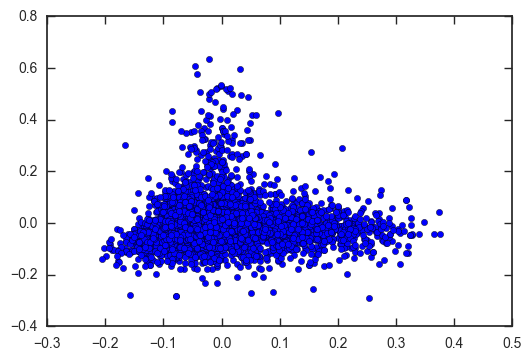

In [72]:
plt.scatter(tpm[:,0], tpm[:,1])

In [73]:
print(pca.explained_variance_ratio_)

[ 0.00957769  0.00838182]


#### Try various numbers of latent features

In [61]:
pca_range = [i for i in range(40)]
pca_variances_cum = []

for num in pca_range:
    pca_obj = PCA(n_components=num)
    pca_fit = pca_obj.fit_transform(tp_dense)
    
    pca_variances_cum.append(sum(pca_obj.explained_variance_ratio_))

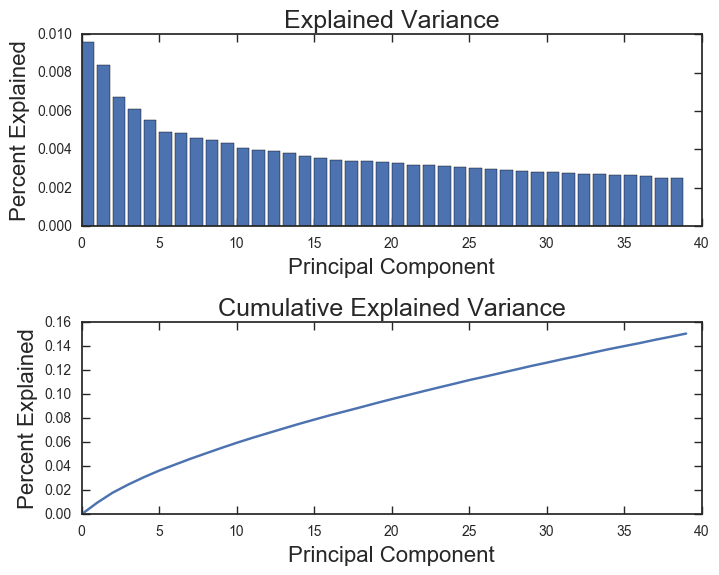

In [62]:
fig, ax = plt.subplots(2,1, figsize=(8,6))

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

# Plot of explained variance
ax1 = ax[0]
ax1.bar([x for x in range(len(pca_obj.explained_variance_ratio_))],pca_obj.explained_variance_ratio_)

ax1.set_title("Explained Variance", size=18)
ax1.set_ylabel("Percent Explained", size=16)
ax1.set_xlabel("Principal Component", size=16)

# Plot of cumulative explained variance
ax2 = ax[1]
ax2.plot([x for x in range(len(pca_variances_cum))], pca_variances_cum)

ax2.set_title("Cumulative Explained Variance", size=18)
ax2.set_ylabel("Percent Explained", size=16)
ax2.set_xlabel("Principal Component", size=16)

## Gauge how the baseline pipeline is running

In [98]:
baseline = pipe.fit_predict(df_test)

### 5 clusters from the DB Scan algorithm

In [99]:
np.unique(baseline)

array([0, 1, 2, 3, 4])

### Append the predicted clusters to the dataframe

In [100]:
df_test['cluster'] = baseline

In [101]:
grouped_df_test = df_test.groupby(['cluster'], as_index=False)

### Randomly draw a subset of reviews from each cluster and look at them individually

In [102]:
sampled_df = sample_cluster(df_test, ['cluster'], size=5)

In [104]:
for doc in sampled_df['reviews']:
    print(doc)

The place was dinky and didn't give you a happy feeling, but the food wasn't bad at all.  I had the pork Vietnamese sandwich, it was pretty good, not great, but pretty good.  And they're always cheap, so no problem there.
Went here on a whim last Friday at lunch time. The cafe is really cute and the staff was friendly. Hey, they even bring your food to you. While here, I had ordered the chicken pesto sandwich which came with a side salad. I have to say that it was just OK. I don't believe it was worth the $10 that I had paid for it. I probably won't order this again. However, I will go back and give it another try :) Stay tuned for another review.
This is the coolest looking Starbucks interior design wise! It is super cool, and I give it 5 stars on that note. I wish I could say the same for the service here. My usual staple order is an iced coffee with caramel syrup--not too complicated, but this location seems to have A LOT of problems keeping orders straight, even the simple drinks. 